
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase1<br>
    Image Segmentation<br>
<font color=696880 size=4>
    Shayan Baghayi Nejad-Armin Khosravi


<font size=5 color=cyan> Names: Alireza Sarbaz, pouria zarei

Student Numbers: 402110876, 402111537 </font>

# Introduction

In this Project, we will become familiar with UNet architecture, Attention mechanism, and Residual blocks with the help of which we will build UNet, AttentionUNet, and ResidualAttentionUnet from scratch using PyTorch framework. The built models will be evaluated by various metrics such as accuracy, Iou score, and Dice score.

### Environment Setup

Here you will find the required packages. Feel free to add the list.

In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import kagglehub
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

### Hyperparameter Setting

Place your hyperparameters' values in the cell below.

In [ ]:
DATA_DIR = '/content/drive/MyDrive/massachusetts-roads-dataset'
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
NUM_WORKERS = 2
LR = 5e-5
NUM_EPOCHS = 15

# Data Preparation

Our task is to segment the [Massachusetts Road Dataset](https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset). You can download this dataset by placing your API Token from kaggle in ```~/.kaggle/``` folder (Instructions can be found in the Kaggle website) and then running the code below.

In [ ]:
path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")

print("Path to dataset files:", path)

If you are running on colab, it is highly recommended to save the dataset to your drive to avoid problems when disconnecting from runtime.

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# shutil.move(path, '/content/drive/MyDrive/')

Mounted at /content/drive


### Loading Images

Load the images and their corresponding masks in two separate lists. (The cell below might take some time to execute.)

In [124]:
def load_images_and_masks(images_path, masks_path, image_size):
    """
    Loads and preprocesses images and their corresponding masks.

    Args:
        images_path (str): Path to the directory containing input images.
        masks_path (str): Path to the directory containing corresponding masks.
        image_size (tuple): Desired size (width, height) to resize images and masks.

    Returns:
        images (np.array): Loaded and resized images.
        masks (np.array): Loaded and resized masks.
    """
    images = []
    masks = []
    failed_files = []

    image_files = sorted(os.listdir(images_path))
    mask_files = sorted(os.listdir(masks_path))

    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        try:
            img_path = os.path.join(images_path, img_file)
            mask_path = os.path.join(masks_path, mask_file)

            image = Image.open(img_path).convert('RGB')
            mask = Image.open(mask_path).convert('L')

            mask_array = np.array(mask, dtype=np.float32) / 255.0
            mask_binary = (mask_array > 0.5).astype(np.uint8) * 255
            mask = Image.fromarray(mask_binary, mode='L')

            image = image.resize(image_size, Image.Resampling.LANCZOS)
            mask = mask.resize(image_size, Image.Resampling.NEAREST)

            image = np.array(image, dtype=np.float32) / 255.0
            mask = np.array(mask, dtype=np.float32) / 255.0

            images.append(image)
            masks.append(mask)

        except Exception as e:
            failed_files.append(f"Error with {img_file}: {str(e)}")
            continue

    images = np.array(images)
    masks = np.array(masks)

    print(f"Successfully loaded {len(images)} images and {len(masks)} masks")
    if failed_files:
        print(f"Failed to load {len(failed_files)} files")

    return images, masks

# Define training image and mask directories
train_images_dir = os.path.join(DATA_DIR, 'tiff/train')
train_masks_dir = os.path.join(DATA_DIR, 'tiff/train_labels')

# Get paths or filenames for training images and masks (placeholder)
train_images_path = train_images_dir
train_masks_path = train_masks_dir

# Load and preprocess training images and masks
train_images, train_masks = load_images_and_masks(train_images_path, train_masks_path, IMAGE_SIZE)

# Define validation image and mask directories
val_images_dir = os.path.join(DATA_DIR, 'tiff/val')
val_masks_dir = os.path.join(DATA_DIR, 'tiff/val_labels')

# Get paths or filenames for validation images and masks (placeholder)
val_images_path = val_images_dir
val_masks_path = val_masks_dir

# Load and preprocess validation images and masks
val_images, val_masks = load_images_and_masks(val_images_path, val_masks_path, IMAGE_SIZE)


/tmp/ipython-input-1995498634.py:31: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask = Image.fromarray(mask_binary, mode='L')


Successfully loaded 1108 images and 1108 masks
Successfully loaded 14 images and 14 masks


### Data Visualization

Display the images and their masks for several samples.

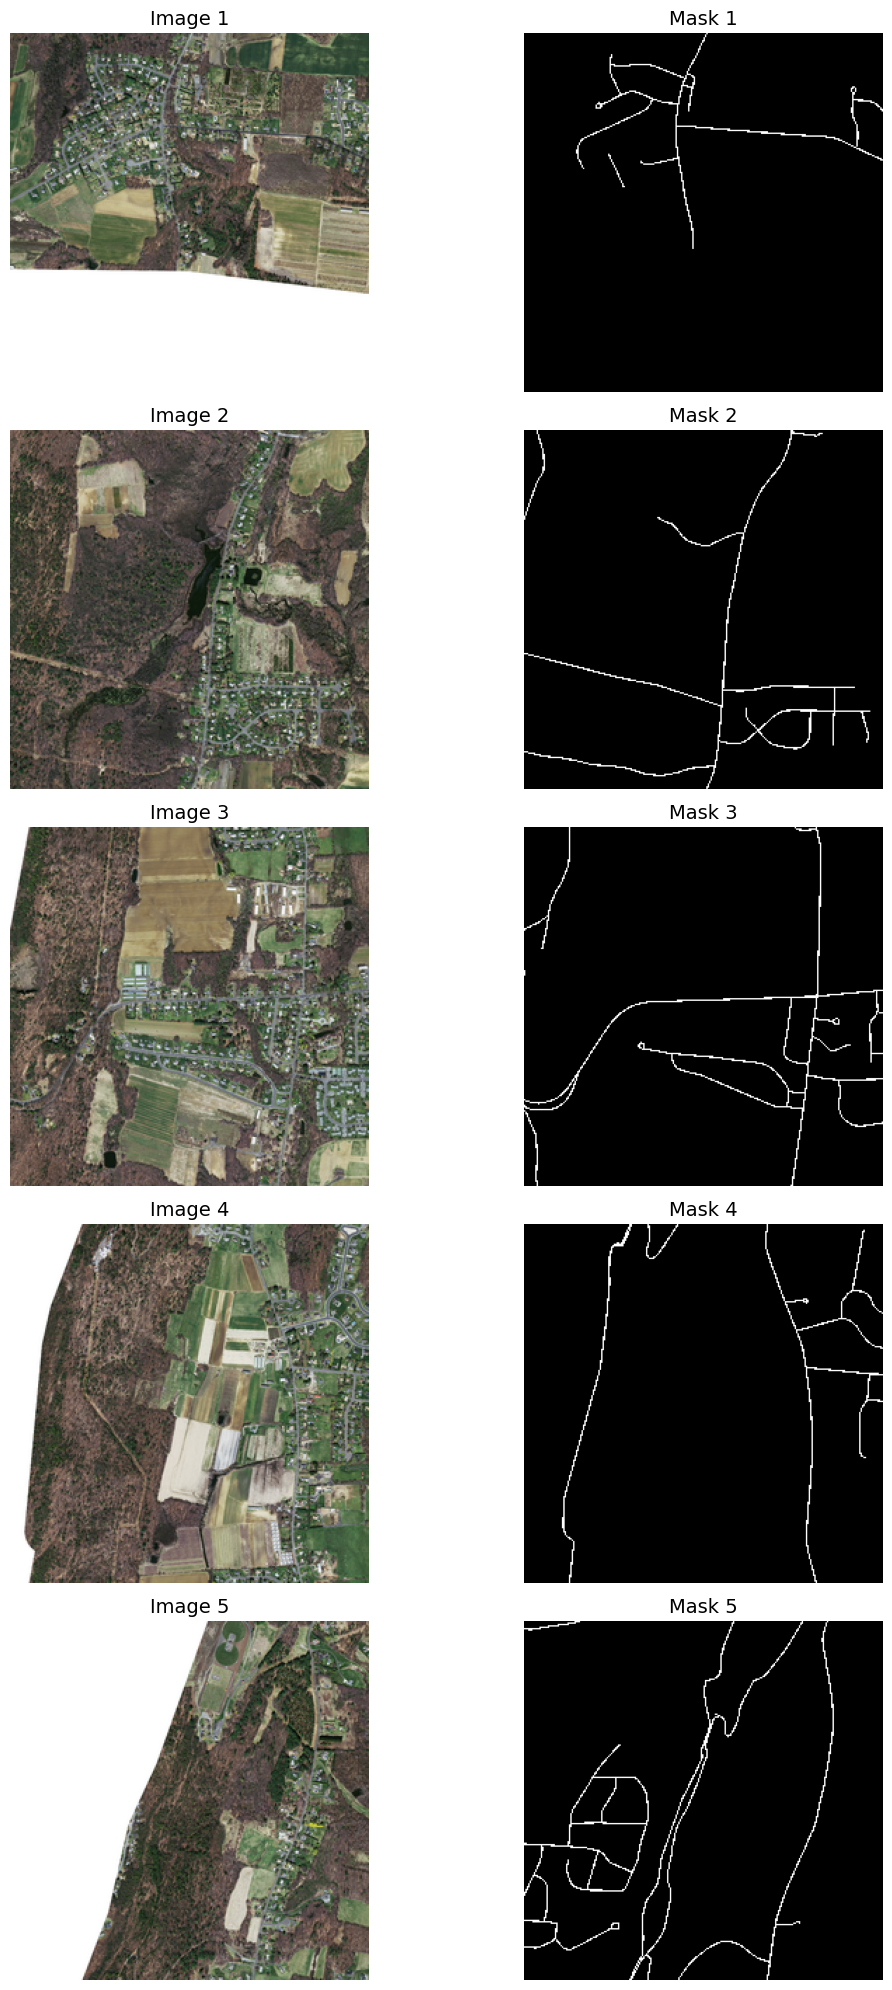

In [125]:
def visualize_images_and_masks(images, masks, n=5):
    """
    Visualizes 'n' images and their corresponding masks side by side.
    Args:
        images (array-like): Collection of input images.
        masks (array-like): Collection of corresponding mask images.
        n (int): Number of image-mask pairs to display.
    """
    plt.figure(figsize=(12, 4 * n))

    for i in range(n):
        # display image
        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(images[i])
        plt.title(f'Image {i+1}', fontsize=14)
        plt.axis('off')

        # display mask
        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title(f'Mask {i+1}', fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images_and_masks(train_images, train_masks, n=5)

### Dataset Creation

Finally, we will make the dataset using the list of images we have stored.

In [126]:
class RoadDataset(Dataset):
    """
    Custom Dataset class for loading road images and their corresponding masks.

    Args:
        images (array-like): List or array of input images.
        masks (array-like): List or array of corresponding masks.
        image_transform (callable, optional): Transformation to apply to the images.
        mask_transform (callable, optional): Transformation to apply to the masks.
    """
    def __init__(self, images, masks, image_transform=None, mask_transform=None):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.image_transform:
            image = self.image_transform(image)
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float()

        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = torch.from_numpy(mask).float()

        return image, mask


image_transform = transforms.Compose([
    transforms.ToTensor(),  # convert numpy array to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),  # convert numpy array to tensor
])

train_dataset = RoadDataset(train_images, train_masks, image_transform, mask_transform)
val_dataset   = RoadDataset(val_images, val_masks, image_transform, mask_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


# UNet

Before proceeding, it is necessary to understand the idea behind UNet. In order to avoid too much details in this notebook, you can read the complete paper for UNet from [this link](https://arxiv.org/pdf/1505.04597).

The overall structure of UNet is provided in the image below.

![UNet Architecture](https://viso.ai/wp-content/uploads/2024/04/unet-process.png)

### Convolution Block

Convolution block is used at each level of UNet.

In [128]:
class ConvBlock(nn.Module):
    """
    A convolutional block consisting of multiple layers (e.g., Conv2D, BatchNorm, ReLU).

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Sequential(
          # conv layer one
          nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_channel),
          nn.ReLU(inplace=True),

          # conv layer two
          nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_channel),
          nn.ReLU(inplace=True)
        )

        for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        return self.conv(x)

### Up Convoluitional Block

We use another block to upsample the latent vector.

In [129]:
class UpConvBlock(nn.Module):
    """
    An upsampling block used in decoder parts of segmentation networks like U-Net.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
      super().__init__()
      self.upconv = nn.Sequential(
            # Transpose convolution
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
      )

      for m in self.modules():
          if isinstance(m, nn.ConvTranspose2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
      return self.upconv(x)

### Complete UNet Structure

Now using the ```ConvBlock``` and ```UpConvBlock``` you created, complete the UNet architecture.

In [130]:
class UNet(nn.Module):
    """
    U-Net architecture for image segmentation tasks.

    Args:
        in_channel (int): Number of input channels (e.g., 3 for RGB images).
        out_channel (int): Number of output channels (e.g., 1 for binary segmentation).
        filter (list): List of filter sizes for each level of the encoder/decoder.
    """
    def __init__(self, in_channel=3, out_channel=1, filter=[64, 128, 256, 512]):
        super().__init__()

        self.encoder1 = ConvBlock(in_channel, filter[0])    # 3→64
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = ConvBlock(filter[0], filter[1])     # 64→128
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = ConvBlock(filter[1], filter[2])     # 128→256
        self.pool3 = nn.MaxPool2d(2)

        self.encoder4 = ConvBlock(filter[2], filter[3])     # 256→512
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(filter[3], filter[3]*2)  # 512→1024

        # Decoder (expansive path)
        self.upconv4 = UpConvBlock(filter[3]*2, filter[3])   # 1024→512
        self.decoder4 = ConvBlock(filter[3]*2, filter[3])    # 1024→512 (after concat)

        self.upconv3 = UpConvBlock(filter[3], filter[2])     # 512→256
        self.decoder3 = ConvBlock(filter[2]*2, filter[2])    # 512→256

        self.upconv2 = UpConvBlock(filter[2], filter[1])     # 256→128
        self.decoder2 = ConvBlock(filter[1]*2, filter[1])    # 256→128

        self.upconv1 = UpConvBlock(filter[1], filter[0])     # 128→64
        self.decoder1 = ConvBlock(filter[0]*2, filter[0])    # 128→64

        # Final output
        self.final_conv = nn.Conv2d(filter[0], out_channel, kernel_size=1)

    def forward(self, x):
        # Encoder + save skip connections
        enc1 = self.encoder1(x)
        x = self.pool1(enc1)

        enc2 = self.encoder2(x)
        x = self.pool2(enc2)

        enc3 = self.encoder3(x)
        x = self.pool3(enc3)

        enc4 = self.encoder4(x)
        x = self.pool4(enc4)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder + skip connections
        x = self.upconv4(x)
        x = torch.cat([x, enc4], dim=1)
        x = self.decoder4(x)

        x = self.upconv3(x)
        x = torch.cat([x, enc3], dim=1)
        x = self.decoder3(x)

        x = self.upconv2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.decoder2(x)

        x = self.upconv1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.decoder1(x)

        return self.final_conv(x)

# Attention UNet

### Attention Mechanism

Attention UNet uses this mechanism to know what part the image is more important to attend to. You can read about this mechanism from [this link](https://arxiv.org/pdf/1706.03762). The Attention mechanism in UNet is described in [this paper](https://arxiv.org/pdf/1804.03999).


![Attention](https://www.researchgate.net/publication/373655981/figure/fig3/AS:11431281186315360@1693879045519/Visualization-of-attention-blocks-reveals-their-functionality-While-the-self-attention.png)

In [131]:
class AttentionBlock(nn.Module):
    """
    Attention block for focusing on relevant features in skip connections.

    Args:
        f_g (int): Number of channels in the gating signal (from decoder).
        f_l (int): Number of channels in the skip connection input (from encoder).
        f_int (int): Number of intermediate channels used within the attention block.
    """
    def __init__(self, f_g, f_l, f_int):
      super().__init__()

      self.w_g = nn.Sequential(
            nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(f_int)
      )

      self.w_x = nn.Sequential(
          nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias=False),
          nn.BatchNorm2d(f_int)
      )

      self.psi = nn.Sequential(
          nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias=False),
          nn.BatchNorm2d(1),
          nn.Sigmoid()
      )

      self.act = nn.ReLU(inplace=True)
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, g, x):
        # g: gating signal from decoder
        # x: feature map from encoder skip connection

        g1 = self.w_g(g)
        x1 = self.w_x(x)

        # Ensure spatial dimensions match
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='bilinear', align_corners=False)

        # Combine and activate
        psi = self.act(g1 + x1)
        psi = self.psi(psi)

        # Apply attention weights
        return x * psi

Now use the ```AttentionBlock``` to inherit [Attention UNet](https://arxiv.org/pdf/1804.03999) from UNet.

> Add blockquote



![Attention UNet](https://www.researchgate.net/publication/347344899/figure/fig6/AS:971357475069952@1608601077414/The-architecture-of-Attention-U-Net-Attention-gate-selects-features-by-using-the.png)

In [132]:
class AttentionUNet(UNet):  # Inherits from UNet
    """
    Attention U-Net architecture which extends the basic U-Net
    by integrating attention blocks in the skip connections.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
        filter_sizes (list): List of filter sizes for each level.
    """
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super().__init__(in_channel, out_channel, filter_sizes)

        # Initialize attention blocks
        self.attention4 = AttentionBlock(f_g=filter_sizes[3], f_l=filter_sizes[3], f_int=filter_sizes[2])
        self.attention3 = AttentionBlock(f_g=filter_sizes[2], f_l=filter_sizes[2], f_int=filter_sizes[1])
        self.attention2 = AttentionBlock(f_g=filter_sizes[1], f_l=filter_sizes[1], f_int=filter_sizes[0])
        self.attention1 = AttentionBlock(f_g=filter_sizes[0], f_l=filter_sizes[0], f_int=filter_sizes[0]//2)

    def forward(self, x):
        # encoder path
        enc1 = self.encoder1(x)
        x = self.pool1(enc1)

        enc2 = self.encoder2(x)
        x = self.pool2(enc2)

        enc3 = self.encoder3(x)
        x = self.pool3(enc3)

        enc4 = self.encoder4(x)
        x = self.pool4(enc4)

        # bottleneck
        x = self.bottleneck(x)

        # decoder path with attention
        x = self.upconv4(x)
        enc4_att = self.attention4(g=x, x=enc4)
        x = torch.cat([x, enc4_att], dim=1)
        x = self.decoder4(x)

        x = self.upconv3(x)
        enc3_att = self.attention3(g=x, x=enc3)
        x = torch.cat([x, enc3_att], dim=1)
        x = self.decoder3(x)

        x = self.upconv2(x)
        enc2_att = self.attention2(g=x, x=enc2)
        x = torch.cat([x, enc2_att], dim=1)
        x = self.decoder2(x)

        x = self.upconv1(x)
        enc1_att = self.attention1(g=x, x=enc1)
        x = torch.cat([x, enc1_att], dim=1)
        x = self.decoder1(x)

        return self.final_conv(x)

# Residual Attention UNet

We will add residual blocks to the attention for better gradient flow. You can read more about residual blocks [here](https://arxiv.org/pdf/1512.03385).

<img src="https://dfzljdn9uc3pi.cloudfront.net/2023/cs-1302/1/fig-1-full.png" width="400" alt="ResUNet Architecture">

In [133]:
class ResidualConvBlock(nn.Module):
    """
    Residual convolutional block with skip connection.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()

        # first convolution path
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )

        # second convolution path
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel)
        )

        # shortcut connection for dimension matching
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channel)
        ) if in_channel != out_channel else nn.Identity()

        self.relu = nn.ReLU(inplace=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.conv2(out)

        identity = self.shortcut(identity)

        # residual addition
        out += identity

        # final activation
        out = self.relu(out)

        return out

Use ```ResidualConvBlock``` to construct Residual Attention Unet.

> Add blockquote



In [134]:
class ResidualAttentionUNet(AttentionUNet):
    """
    Residual Attention U-Net combining residual blocks with attention mechanisms.
    """
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super().__init__(in_channel, out_channel, filter_sizes)

        # replace all convBlocks
        self.encoder1 = ResidualConvBlock(in_channel, filter_sizes[0])
        self.encoder2 = ResidualConvBlock(filter_sizes[0], filter_sizes[1])
        self.encoder3 = ResidualConvBlock(filter_sizes[1], filter_sizes[2])
        self.encoder4 = ResidualConvBlock(filter_sizes[2], filter_sizes[3])
        self.bottleneck = ResidualConvBlock(filter_sizes[3], filter_sizes[3]*2)
        self.decoder4 = ResidualConvBlock(filter_sizes[3]*2, filter_sizes[3])
        self.decoder3 = ResidualConvBlock(filter_sizes[2]*2, filter_sizes[2])
        self.decoder2 = ResidualConvBlock(filter_sizes[1]*2, filter_sizes[1])
        self.decoder1 = ResidualConvBlock(filter_sizes[0]*2, filter_sizes[0])

    def forward(self, x):
        enc1 = self.encoder1(x)
        x = self.pool1(enc1)

        enc2 = self.encoder2(x)
        x = self.pool2(enc2)

        enc3 = self.encoder3(x)
        x = self.pool3(enc3)

        enc4 = self.encoder4(x)
        x = self.pool4(enc4)

        x = self.bottleneck(x)

        x = self.upconv4(x)
        enc4_gated = self.attention1(g=x, x=enc4)
        x = torch.cat([x, enc4_gated], dim=1)
        x = self.decoder4(x)

        x = self.upconv3(x)
        enc3_gated = self.attention2(g=x, x=enc3)
        x = torch.cat([x, enc3_gated], dim=1)
        x = self.decoder3(x)

        x = self.upconv2(x)
        enc2_gated = self.attention3(g=x, x=enc2)
        x = torch.cat([x, enc2_gated], dim=1)
        x = self.decoder2(x)

        x = self.upconv1(x)
        enc1_gated = self.attention4(g=x, x=enc1)
        x = torch.cat([x, enc1_gated], dim=1)
        x = self.decoder1(x)

        return self.final_conv(x)

# Training

Now it is time to train the model on training data.

### Loss Function

We will be using the sum of [Dice Score](https://oecd.ai/en/catalogue/metrics/dice-score#:~:text=The%20Dice%20score%20is%20calculated,sizes%20of%20the%20two%20sets.), [Iou Score](https://www.v7labs.com/blog/intersection-over-union-guide), and Binary Cross Entropy as loss function. You can read about the mentioned scores in the provided links.

<font color=cyan><b> Note: Do Not Change The ```OverallLoss``` Function as it is used for measuring you model's performance.</b></font>

In [135]:
### DICE LOSS
class DiceLoss(nn.Module):
    """
    Dice Loss for measuring overlap between predicted and ground truth masks.
    Particularly useful for imbalanced classes in segmentation tasks.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred = pred.view(-1)
        real = real.view(-1)

        # calculate intersection: |A ∩ B|
        intersection = (pred * real).sum()

        # calculate Dice coefficient: 2 * |A ∩ B| / (|A| + |B|)
        dice_coeff = (2. * intersection + self.smooth) / (pred.sum() + real.sum() + self.smooth)

        return 1 - dice_coeff


### Iou Loss
class IouLoss(nn.Module):
    """
    Intersection over Union (IoU) Loss for segmentation evaluation.
    Measures the overlap between predicted and ground truth masks.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(IouLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred = pred.view(-1)
        real = real.view(-1)

        # calculate intersection: |A ∩ B|
        intersection = (pred * real).sum()

        # calculate union: |A ∪ B| = |A| + |B| - |A ∩ B|
        union = pred.sum() + real.sum() - intersection

        # calculate IoU coefficient: |A ∩ B| / |A ∪ B|
        iou_coeff = (intersection + self.smooth) / (union + self.smooth)

        return 1 - iou_coeff


### Overall Loss (DO NOT CHANGE)
class OverallLoss(nn.Module):
    """
    Combined loss function that sums Dice loss, IoU loss, and Binary Cross-Entropy loss.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(OverallLoss, self).__init__()
        self.dice_loss = DiceLoss(smooth)
        self.iou_loss = IouLoss(smooth)
        self.bce_loss = nn.BCELoss()

    def forward(self, pred, real):
        dice = self.dice_loss(pred, real)
        iou = self.iou_loss(pred, real)
        bce = self.bce_loss(pred, real)

        return dice, iou, bce, dice+iou+bce

### Training Epoch

Complete the function below to train the model for one epoch.

In [136]:
def train_one_epoch(model, optimizer, criterion, data_loader, scheduler=None, device='cuda'):
    total_loss = 0.0
    model.train()
    for i, (img, mask) in enumerate(tqdm(data_loader)):
        img = img.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()

        pred = model(img)

        pred = torch.sigmoid(pred).squeeze(1)  # (batch, 1, H, W) -> (batch, H, W)

        if mask.dim() == 4:
            mask = mask.squeeze(1)  # (batch, 1, H, W) -> (batch, H, W)

        _, _, _, loss = criterion(pred, mask)

        loss.backward()

        optimizer.step()

        if scheduler:
            scheduler.step()

        total_loss += loss.item()

    return total_loss/len(data_loader)

Design a function for evaluation after each training phase.

In [137]:
def evaluate_model(model, criterion, data_loader, device='cuda'):
    total_loss = 0.0
    iou_score = 0.0
    dice_score = 0.0
    model.eval()

    with torch.no_grad():
        for i, (img, mask) in enumerate(tqdm(data_loader)):
            img = img.to(device)
            mask = mask.to(device)

            pred = model(img)
            pred = torch.sigmoid(pred).squeeze(1)

            if mask.dim() == 4:
                mask = mask.squeeze(1)

            dice_loss, iou_loss, bce_loss, overall_loss = criterion(pred, mask)

            total_loss += overall_loss.item()
            iou_score += 1 - iou_loss.item()
            dice_score += 1 - dice_loss.item()

        total_loss /= len(data_loader)
        iou_score /= len(data_loader)
        dice_score /= len(data_loader)

    return total_loss, iou_score, dice_score

# Model Training

### UNet  
Create an instance of UNet and train it. Then report the results.  

<b><font color=red>Note: your models need to satisfy below conditions to get complete score.</font></b>

<table style="width: 100%; font-size: 18px; border-collapse: collapse; margin: 15px 0;">
  <tr>
    <th style="text-align: left; padding: 8px; border-bottom: 2px solid #ddd;">Model</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Validation Loss</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Iou Score</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Dice Score</th>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 1.0</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.5</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">Attention UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 0.9</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.65</td>
  </tr>
  <tr>
    <td style="padding: 8px;">Residual Attention UNet</td>
    <td style="text-align: right; padding: 8px;">&lt; 0.8</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.65</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.7</td>
  </tr>
</table>

In [ ]:
unet = UNet().to(device)
criterion = OverallLoss()
optimizer = Adam(unet.parameters(), lr=LR)

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(unet, optimizer, criterion, train_loader, device=device)
    val_loss, iou_score, dice_score = evaluate_model(unet, criterion, val_loader, device=device)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(unet.state_dict(), "best_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 2/2 [00:00<00:00,  4.16it/s]


Iteration 1/15: Train Loss: 2.32 | Val Loss: 2.21 | Iou Score: 0.09 | Dice Score: 0.16


 22%|██▏       | 31/139 [00:14<00:51,  2.10it/s]

Now do the same for Attention UNet and Reidual Attention UNet.

In [ ]:
attention_unet = AttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(attention_unet.parameters(), lr=LR)

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(attention_unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(attention_unet, criterion, val_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(attention_unet.state_dict(), "best_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

For Residual Attention UNet, plot the changes in train and validation loss.

In [ ]:
resattn_unet = ResidualAttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(resattn_unet.parameters(), lr=LR)

train_losses = []
val_losses = []

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(resattn_unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(resattn_unet, criterion, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        torch.save(resattn_unet.state_dict(), "best_residual_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

Now Visualize losses.

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, 'r-', label='Training Loss', linewidth=2)
plt.plot(val_losses, 'b-', label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Prediction Visualisation

Display several images, their masks, and the predicted mask by your model.

In [ ]:
def visualize_image_mask_prediction(images, masks, predictions, n=5):
    plt.figure(figsize=(15, 4 * n))

    for i in range(n):
        pred_binary = (predictions[i] > 0.5).astype(float)
        mask_binary = masks[i]
        accuracy = np.mean(pred_binary == mask_binary)

        plt.subplot(n, 3, 3*i + 1)
        if len(images[i].shape) == 3:
            plt.imshow(images[i])
        else:
            plt.imshow(images[i], cmap='gray')
        plt.title(f'Image {i+1}', fontsize=14)
        plt.axis('off')

        plt.subplot(n, 3, 3*i + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title(f'Ground Truth {i+1}', fontsize=14)
        plt.axis('off')

        plt.subplot(n, 3, 3*i + 3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title(f'Predicted {i+1} | accuracy: {accuracy:.2f}', fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_image_mask_prediction(val_images, val_masks, n=5)